# Welcome to the data science journey!
We are going to build a churn model for an imaginary bank! The whole notebook demonstrates my daily workflow.<br>
Some of the codes here may be quite tedious and can be avoided by using some self-constructed libraries in practice. To make it self-contain, I wiil only use some common libraries. <br>
Hope you enjoy this journey, we will start our jounery with importing common libraries and reading data.<br>

xgboost version: 0.90 <br>
sklearn version: 0.22.2.post1 <br>
lightgbm version: 2.2.3

In [2]:
from dateutil.relativedelta import relativedelta 
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
devices_raw = pd.read_csv('data/devices.csv')
notifications_raw = pd.read_csv('data/notifications.csv', parse_dates=['created_date'])
users_raw = pd.read_csv('data/users.csv', parse_dates=['created_date'])
transactions_raw = pd.read_csv('data/transactions.csv', parse_dates=['created_date'])

Since the data is highly confidential so I can only show the schema of the datasets.

In [8]:
display(devices_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    19430 non-null  object
 1   user_id  19430 non-null  object
dtypes: object(2)
memory usage: 303.7+ KB


None

In [9]:
display(notifications_raw.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121813 entries, 0 to 121812
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   reason        121813 non-null  object        
 1   channel       121813 non-null  object        
 2   status        121813 non-null  object        
 3   user_id       121813 non-null  object        
 4   created_date  121813 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 4.6+ MB


None

In [10]:
display(users_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19430 entries, 0 to 19429
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   user_id                                   19430 non-null  object        
 1   birth_year                                19430 non-null  int64         
 2   country                                   19430 non-null  object        
 3   city                                      19430 non-null  object        
 4   created_date                              19430 non-null  datetime64[ns]
 5   user_settings_crypto_unlocked             19430 non-null  int64         
 6   plan                                      19430 non-null  object        
 7   attributes_notifications_marketing_push   12820 non-null  float64       
 8   attributes_notifications_marketing_email  12820 non-null  float64       
 9   num_contacts                

None

In [11]:
display(transactions_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740075 entries, 0 to 2740074
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   transaction_id         object        
 1   transactions_type      object        
 2   transactions_currency  object        
 3   amount_usd             float64       
 4   transactions_state     object        
 5   ea_cardholderpresence  object        
 6   ea_merchant_mcc        float64       
 7   ea_merchant_city       object        
 8   ea_merchant_country    object        
 9   direction              object        
 10  user_id                object        
 11  created_date           datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 250.9+ MB


None

First, to build a model classifying clients as engaged or unengaged, we have to define the meaning of the client being unengaged.<br>
As a bank, we can easily say a client is unengaged (or churns) when he/she did not use our service for a while.<br>
But what do we mean by 'a while'? <br>
Let's look at the transaction data and see whether there are any hints! <br>

To start, for a transaction with 0 dollars, it is probably a record generated by the system.
It does not necessary a transaction done by the client, so we will ignore those transactions

In [0]:
id_and_trans = transactions_raw[transactions_raw['amount_usd'] > 0].copy()
id_and_trans = id_and_trans[['user_id', 'created_date']].sort_values(['user_id', 'created_date'])
id_and_trans['time_until_next_transaction'] = -id_and_trans.groupby('user_id')['created_date'].diff(-1)
# to better visualize the data, we will change the unit to week instead of a long long yymmdd hhmmss format 
days_until_next_trans = id_and_trans['time_until_next_transaction'].dt.days
week_until_next_trans = days_until_next_trans // 7

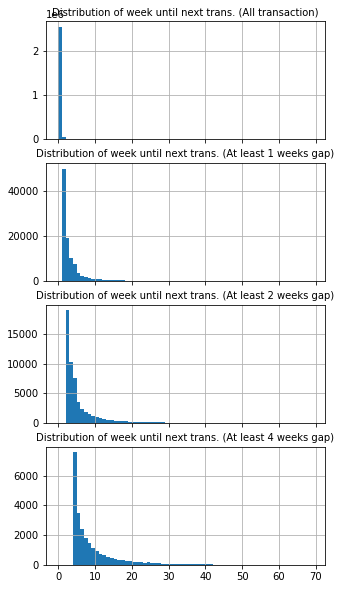

In [0]:
fig, ax = plt.subplots(4, 1, sharex=True)

ax[0].set_title('Distribution of week until next trans. (All transaction)', fontsize=10)
week_until_next_trans.hist(ax=ax[0], figsize=(5,10), bins=range(0,70))

ax[1].set_title('Distribution of week until next trans. (At least 1 weeks gap)', fontsize=10)
week_until_next_trans[week_until_next_trans>=1].hist(ax=ax[1], figsize=(5,10), bins=range(0,70))

ax[2].set_title('Distribution of week until next trans. (At least 2 weeks gap)', fontsize=10)
week_until_next_trans[week_until_next_trans>=2].hist(ax=ax[2], figsize=(5,10), bins=range(0,70))

ax[3].set_title('Distribution of week until next trans. (At least 4 weeks gap)', fontsize=10)
week_until_next_trans[week_until_next_trans>=4].hist(ax=ax[3], figsize=(5,10), bins=range(0,70))

### Main take away for Q2

In [0]:
print('95% percent of the transactions will be followed by another transaction within {} days'.format(days_until_next_trans[days_until_next_trans > 0].quantile(0.95)))

95% percent of the transactions will be followed by another transaction within 28.0 days


Since most of the client will follow another trade within 28 days, to optimize the resource, we may just focus on re-engaging the clients at the tail,
so we will say a client is unengaging if he/she has <b>no transaction within the next 28 days</b>. <br>

Besides, as the model only consider the time in the coming 28 days and does not consider the possibility that the client will come back long long time later, so the model will see an unengaging client as a churn client.<br>

This is quite similar to the execution level if we predict that the client will cease using the bank in the coming 28 days. It does not quite make sense to wait the client come back a long time later and stopping doing anything from retaining the client.<br>
Therefore, at the model perspective, we will see <b>unengaging clients as churn clients</b>.<br>

Now, the model should assign a churn probability to each client. <br>
To make the model easier to execute in the production environment,
we will try to assign a score to the client once a week (batch scoring). <br>
Using the information in the past, we would like to predict whether the 
client's next transaction will be conducted after 28 days.

### Data manipulations (Feature Extraction)
This part will mainly focus on some generating features manually,
which is quite tedious and lengthy, some are with insights and some are by heuristics. <br>

We will tackle the 4 csv files one by one.
The final goal is to build a data frame that each row stores some summary statistics of each client at each snapshot (each week).

In [0]:
# The user_id for devices table is unique
# Most of the devices people use are either Apple or Android, we will binary encode the brand
devices = devices_raw.copy().set_index('user_id')
devices['brand'] = devices['brand'].map({'Android': 1, 'Apple': 0, 'Unknown': np.NaN})

In [0]:
users = users_raw.copy()
users = users.rename({'created_date': 'account_created_date'}, axis=1)
users['account_created_date'] = pd.to_datetime(users['account_created_date'])

# Order the 'Plan' by the plan level,
# and add an indicator to flag out whether the clients was given an upgrade offer
users['plan_level'] = users['plan'].replace({'STANDARD': 0,
                                             'PREMIUM': 1, 'PREMIUM_OFFER': 1, 'PREMIUM_FREE': 1,
                                             'METAL': 2, 'METAL_FREE': 2})
users['plan_discount'] = users['plan'].replace({'STANDARD': 0, 'PREMIUM': 0, 'METAL': 0,
                                                'PREMIUM_OFFER': 1, 'PREMIUM_FREE': 1, 'METAL_FREE': 1})

# Note that all entries in 'num_successful_referrals' and 'num_referrals' are the same,
# we may just drop this entry. Also, the distribution of city is too sparse, we can use the 'country' variable
users.drop(['num_successful_referrals', 'num_referrals', 'plan', 'city'], axis=1, inplace=True)

In [0]:
transactions = transactions_raw.copy()
transactions = transactions.rename({'created_date': 'transaction_date'}, axis=1)
transactions['transactions_state'] = transactions['transactions_state'].replace({'FAILED': 'TRANSACTION_FAILED'})

# over 40% of the entries about starts with ea are null
# which is what we should improve for the database system!
# This time we may drop them first.
transactions.drop(['ea_merchant_city', 'ea_cardholderpresence', 'ea_merchant_mcc'], axis=1, inplace=True)
transactions['direction'] = transactions['direction'].map({'INBOUND': 0, 'OUTBOUND': 1})

In [0]:
notifications = notifications_raw.copy()
notifications = notifications.rename({'created_date': 'message_created_date'}, axis=1)
notifications['status'] = notifications['status'].replace({'FAILED': 'MESSAGE_FAILED'})

# Note that some types of notification reason appear only in a later period of the data set, 
# such at promotional reasons like 'ONBOARDING_TIPS_ACTIVATED_USERS' only appear after June 2018
# and only reactivation reasons like 'NO_INITIAL_CARD_ORDER' or 'NO_INITIAL_CARD_USE' appear before June 2018
# we will drop the reason column and we will see why later.
notifications.drop('reason', inplace=True, axis=1)

In [0]:
# Now, we are make a series of pivot_table, with the row as user_id and column and the domain values of categorical variables
# Since some domain values only appear in certain month.
domain_values = {}
domain_values['transactions_type'] = transactions['transactions_type'].unique()
domain_values['transactions_state'] = transactions['transactions_state'].unique()
domain_values['channel'] = notifications['channel'].unique()
domain_values['status'] = notifications['status'].unique()

### Data Transformation pipeline

After some general data manipulations, we will start to split our data into train and test set. <br>

The transaction records are from 2018 Jan to 2019 May, we will use the records in 2018 to train the model
and 2019 data to test the model. <br>

The reason is simple, after we train a model, since we don't want to keep re-training the model regularly, 
we should ensure the model is valid from time to time. Therefore the time out-of-time validation set is necessary for the task.<br>

And that is why we drop the 'reason' columns previously!

In [0]:
# We will give a score to the client every 7 days,
# so we will make a snapshot at every 7 days and create a dataframe for training
time_periods = []
snap_shot_date = pd.to_datetime('2018-02-01')
while snap_shot_date < pd.to_datetime('2019-01-01'):
    time_periods.append(snap_shot_date)
    snap_shot_date = snap_shot_date + relativedelta(snap_shot_date, days=7)

After splitting the data set to train and validation set, 
we can generate some complicated features without an afraid of a data leak. <br>

To ensure that the same pipeline is applied across train and test set, 
we will write a simple function for this process. 

In general, one should conduct exploratory analysis and try to generate golden features and add to the data manipulation pipeline. <br>

To make the code much more structured and avoid copying the same code, 
we will first create the pipeline and
then plot out the graphs after creating the pipeline.

In [0]:
def data_transformation_pipeline(start_time, end_time):
    snap_shot_dates = []
    snap_shot_date = pd.to_datetime(start_time)
    while snap_shot_date < pd.to_datetime(end_time):
        snap_shot_dates.append(snap_shot_date)
        snap_shot_date = snap_shot_date + relativedelta(snap_shot_date, days=7)

    df_all_months = {}
    for snap_shot_date in snap_shot_dates:
        # We will use past one month data to create summary statsics
        snap_shot_beg = pd.to_datetime(snap_shot_date)
        snap_shot_end = snap_shot_beg + relativedelta(snap_shot_beg, months=1)

        # Of course, we will only include clients have account before the snapshot_day!
        users_1m = users[users['account_created_date'] < snap_shot_end].copy().set_index('user_id')
        users_1m['age'] = snap_shot_end.year - users_1m['birth_year']
        users_1m['days_since_account_opened'] = (snap_shot_end - users_1m['account_created_date']).dt.days
        users_1m = users_1m.merge(devices, left_index=True, right_index=True, how='left')

        # To prevent data leak, we will only use the summary of past 7 days
        trans_beg = snap_shot_end + relativedelta(snap_shot_end, days=-7)
        transactions_7d = transactions[(trans_beg <= transactions['transaction_date'] ) & (transactions['transaction_date'] < snap_shot_end)].copy()
        next_transaction_date = transactions[transactions['transaction_date'] >= snap_shot_end].groupby('user_id')['transaction_date'].min()

        # counting past some 7days transaction summaries
        trans_summary_7d = pd.DataFrame(transactions_7d.groupby('user_id')['amount_usd'].mean())
        trans_summary_7d = trans_summary_7d.rename({'amount_usd': 'mean_transaction_7d'}, axis=1).sort_index()
        trans_summary_7d['std_transaction_7d'] = transactions_7d.groupby('user_id')['amount_usd'].std() 
        trans_summary_7d['direction'] = transactions_7d.groupby('user_id')['direction'].mean()
        trans_summary_7d['transactions_currency'] = transactions_7d.groupby('user_id')['transactions_currency'].nunique()
        trans_summary_7d['days_unitl_next_transation'] = (next_transaction_date - snap_shot_end).dt.days

        # As we have mentioned, we will say a client is churns if he has no transaction in the next 28 days
        trans_summary_7d['churn'] = trans_summary_7d['days_unitl_next_transation'] > 28
        trans_summary_7d.drop(['days_unitl_next_transation'], axis=1, inplace=True)

        # A series of pivot table now
        data_to_concat = []
        for column in ['transactions_type', 'transactions_state']:
            # To make a pivot table which store the count for different domain values
            temp = transactions_7d.pivot_table(index='user_id',
                                               columns=column,
                                               values='transaction_id',
                                               aggfunc='count',
                                               fill_value=0).sort_index()
            for domain_value in domain_values[column]:
                if domain_value not in temp.columns:
                    temp[domain_value] = 0 
            temp = temp[domain_values[column]]
            data_to_concat.append(temp)

        # We would like to see whether a notification in past 1 month will make the client 
        # uses our bank in long term (lower churn rate)
        notifications_1m = notifications[(snap_shot_beg <= notifications['message_created_date'] ) & (notifications['message_created_date'] < snap_shot_end)].copy()
        for column in ['status', 'channel']:
            # To make a pivot table which store the count for different domain values
            temp = notifications_1m.pivot_table(index='user_id',
                                                columns=column,
                                                values='message_created_date',
                                                aggfunc='count',
                                                fill_value=0).sort_index()
            for domain_value in domain_values[column]:
                if domain_value not in temp.columns:
                    temp[domain_value] = 0 
            temp = temp[domain_values[column]]
            data_to_concat.append(temp)
        noti_cnt_1m = notifications_1m.groupby('user_id')['message_created_date'].count()

        # concating all the result
        df_1m = pd.concat([users_1m, noti_cnt_1m] + data_to_concat , axis=1, join='outer', sort=False)
        # Also notice some some 'attributes_notifications_marketing_push' and 'attributes_notifications_marketing_email' are missing
        # This information is input at the time the user join out bank
        # From time to time, the client may change his preference
        # So whenever he received a message in this month, we will fill the na as 1, else 0
        df_1m['attributes_notifications_marketing_push'] = df_1m[['attributes_notifications_marketing_push', 'PUSH']].fillna(0).max(axis=1) > 0
        df_1m['attributes_notifications_marketing_email'] = df_1m[['attributes_notifications_marketing_push', 'EMAIL']].fillna(0).max(axis=1) > 0
        df_1m.drop(['birth_year', 'account_created_date'], axis=1, inplace=True)

        # A left join is used with the past 7days transaction data as the base,
        # If the client has no transaction in past 7days, we may use the previous score.
        df_1m = trans_summary_7d.merge(df_1m, left_index=True, right_index=True, how='left')
        df_all_months[snap_shot_date] = df_1m

    df = pd.concat(df_all_months.values()).rename({'message_created_date': 'num_messages_1m'}, axis=1)
    # the more transaction in that country, the more people know our bank,
    # And more people will use it! (hopefully)
    # Frequency encoding for the country entry
    df['country'] = df['country'].map(df['country'].value_counts())
    return df.fillna(0)

In [0]:
df_train = data_transformation_pipeline('2018-02-01', '2019-01-01')

### Exploratory Data Analysis
After creating a pipeline of data manipulation, let's do some explanatory data analysis to get a feeling of
whether the variable is useful!

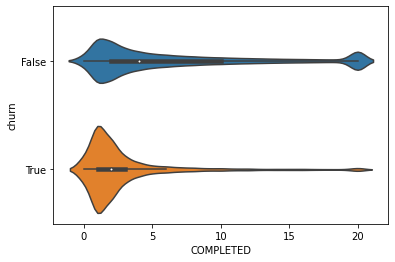

In [0]:
sns.violinplot(x=df_train['COMPLETED'].clip(upper=20),
        y=df_train['churn'], orient='h')
# one can see that in general, the more completed transaction in the past 7 days,
# the (slightly) lower chance the client churns in the future.

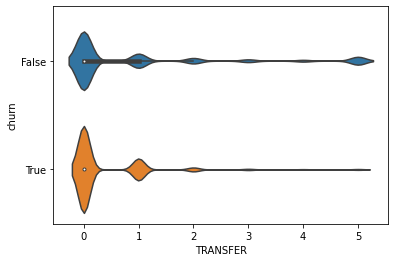

In [0]:
sns.violinplot(x=df_train['TRANSFER'].clip(upper=5), y=df_train['churn'], orient='h')
# Similarly, the more completed transfer in the past 7 days
# the low chance the client churns in the future.
# These factors means that the active users will stick to out bank, 
# which is very common as banking service traditionally has high stickiness
# Maybe some our marketing team has to think of converting those one-off users?

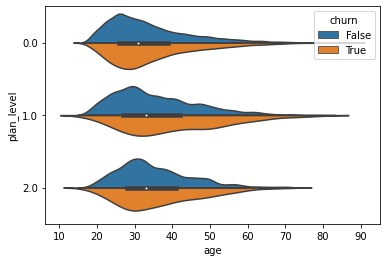

In [0]:
sns.violinplot(x=df_train['age'],
               y=df_train['plan_level'],
               hue=df_train['churn'],
               split=True,
               orient='h')
# Here, for the plan_level Standard (0) and Metal (2), it may be a little bit difficult to tell
# but for Premium (1), it seems that younger premium account holder tends to keep engaging
# with our bank!

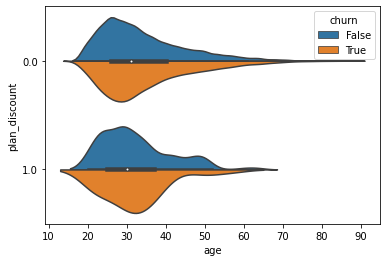

In [0]:
sns.violinplot(x=df_train['age'],
               y=df_train['plan_discount'],
               hue=df_train['churn'],
               split=True, orient='h')
# This graph has an interesting finding.
# Given that the client was offered a discount,
# the churn propensity does is not monotonic across the age!
# the account upgrade offer is slightly more loyal to our bank if he is below 30 and above 40
# but it is not the case for 30 to 40!
# To target this age group, giving an upgrade offer may not
# be useful to build a long term relationship with them.
# That is very normal since they are potentially some middle management 
# of a company, they are getting wealthy and look at things other than fees.
# Maybe a better user experience is more important to them?

In [0]:
# There are lots of EDA can be done.
# In fact, one can also look at some of the basic statistic
# and get a sense of which one is a useful variable
df_train.groupby('churn').mean().T[:10]

# For example, the std_transaction_7d has a large difference in two groups
# one may expect that std_transaction_7d may be one of the important variables to
# separate two groups

churn,False,True
mean_transaction_7d,317975.940951,1.606379e+06
std_transaction_7d,464218.834375,1.516723e+02
direction,0.766963,6.731982e-01
transactions_currency,1.223369,1.154992e+00
country,30429.041216,3.205932e+04
user_settings_crypto_unlocked,0.270969,1.799828e-01
attributes_notifications_marketing_push,0.714957,6.799212e-01
attributes_notifications_marketing_email,0.749317,7.220854e-01
num_contacts,21.583220,1.612317e+01
plan_level,0.190766,5.890681e-02


### Model Training

In [0]:
# A standard train test split and parameter search
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('churn', axis=1),
                                                    df_train['churn'],
                                                    stratify=df_train['churn'],
                                                    random_state=77)

In general, tree models dont really need to worry about the outliers <br>
We may compare the results of XGBoost, LightGBM and Random Forest. <br>
The param_grid below starts from a wider range and iteratively test and tune 
to shrink to the range you can see. <br>
For demonstration purpose, we will only set n_iter=10.

In [0]:
%%time
xgb_clf = XGBClassifier(random_state=77, n_jobs=-1)
xgb_param_grid = {'n_estimators': range(10, 100),
               'reg_alpha': np.arange(5, 20, 0.1),
               'reg_lambda': np.arange(5, 20, 0.1),
               'subsample': np.arange(0.5, 1, 0.01),
               'learning_rate': np.arange(0.05, 0.5, 0.01),
               'scale_pos_weight': np.arange(1, 3, 0.1),
               'max_depth': range(3, 10)}
xgb_searching_cv = RandomizedSearchCV(xgb_clf, 
                               xgb_param_grid, 
                               scoring='roc_auc',
                               n_iter=10, 
                               cv=5,
                               return_train_score=True,
                               random_state=77,
                               n_jobs=-1)
xgb_searching_cv.fit(X_train, y_train)

CPU times: user 41 s, sys: 496 ms, total: 41.5 s
Wall time: 7min


In [0]:
%%time
lgb_clf = lgb.LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=77)
lgb_param_grid = {'n_estimators': range(10, 100),
               'reg_alpha': np.arange(5, 20, 0.1),
               'reg_lambda': np.arange(5, 20, 0.1),
               'subsample': np.arange(0.5, 1, 0.01),
               'learning_rate': np.arange(0.05, 0.5, 0.01),
               'scale_pos_weight': np.arange(1, 3, 0.1),
               'max_depth': range(3, 10)}
lgb_searching_cv = RandomizedSearchCV(lgb_clf, 
                               lgb_param_grid, 
                               scoring='roc_auc',
                               n_iter=10, 
                               cv=5,
                               return_train_score=True,
                               random_state=77,
                               n_jobs=-1)
lgb_searching_cv.fit(X_train, y_train)

CPU times: user 10 s, sys: 288 ms, total: 10.3 s
Wall time: 1min 1s


In [0]:
%%time
rf_clf = RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1, random_state=77)
rf_param_grid = {'n_estimators': range(50, 500, 50),
              'max_depth': range(3, 10),
              'min_samples_split': range(2, 200, 10)}
rf_searching_cv = RandomizedSearchCV(rf_clf, 
                               rf_param_grid, 
                               scoring='roc_auc',
                               cv=5,
                               return_train_score=True,
                               random_state=77,
                               n_jobs=-1)
rf_searching_cv.fit(X_train, y_train)

CPU times: user 1min 45s, sys: 1.36 s, total: 1min 47s
Wall time: 11min 36s


As the random forest is a bagging algorithm whereas XGB and LGMB are boosting. <br>
It may be unfair to compare them using running time, <br>
but at the very beginning, we see that LGBM runs much faster than others. <br>
Let see how the model performance in terms of the roc_auc_score. <br>

In [0]:
def cv_evaluation(searching_cv):
    cv_score = pd.DataFrame({'mean_train_score': searching_cv.cv_results_['mean_train_score'],
                        'mean_test_score': searching_cv.cv_results_['mean_test_score']})
    # To aviod overfit, we only choose parameters such that the train_score and test_score are very close
    cv_score['train_test_difference'] = cv_score['mean_train_score'] - cv_score['mean_test_score']
    no_overfit_candidate = cv_score[cv_score['train_test_difference'] < 0.025]
    display(no_overfit_candidate)

In [0]:
print('The result of XGB:')
cv_evaluation(xgb_searching_cv)
print('The result of LGBM:')
cv_evaluation(lgb_searching_cv)
print('The result of RF:')
cv_evaluation(rf_searching_cv)

The result of XGB:


,mean_train_score,mean_test_score,train_test_difference
4,0.765876,0.754973,0.010902
6,0.763855,0.751829,0.012025


The result of LGBM:


,mean_train_score,mean_test_score,train_test_difference
3,0.777767,0.755856,0.021911
4,0.768704,0.755582,0.013123
5,0.775027,0.756094,0.018934
6,0.770563,0.754956,0.015607


The result of RF:


,mean_train_score,mean_test_score,train_test_difference
0,0.761512,0.747196,0.014316
1,0.752635,0.744267,0.008368
2,0.738833,0.735648,0.003185
3,0.769769,0.748548,0.021221
4,0.761325,0.747240,0.014085
5,0.734110,0.732061,0.002050
7,0.733773,0.731860,0.001913
8,0.760393,0.747129,0.013265
9,0.770051,0.748824,0.021227


One can see that for RF, mean_test_score are in general lower than
XGB and LGBM, considering the running time, as XGB's running time is about 5 times of LGBM's, even though some parameters of XGB have lower tran_test_difference (more stable), we would choose LGBM as our final model. <br> 
Also, to balance between the need for high mean_test_score and low train_test_difference, 
I would like to choose the 4th set of parameters.

In [0]:
final_params = lgb_searching_cv.cv_results_['params'][4]
clf = lgb.LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=103, **final_params)
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.08000000000000002, max_depth=4,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=83, n_jobs=-1, num_leaves=31, objective=None,
               random_state=103, reg_alpha=5.1, reg_lambda=16.69999999999996,
               scale_pos_weight=2.300000000000001, silent=True,
               subsample=0.8700000000000003, subsample_for_bin=200000,
               subsample_freq=0)

In [0]:
def evaluation(X, y, model):
    y_pred = clf.predict_proba(X)[:, 1]
    print('The roc auc score is: {}'.format(roc_auc_score(y, y_pred)))
    result_table = pd.DataFrame({'Predict_proba': y_pred, 'churn': y}).sort_values('Predict_proba', ascending=False)
    result_table['rank'] = range(result_table.shape[0])
    result_table['count'] = 1
    result_table['percentile'] = (pd.qcut(result_table['rank'], 5, labels=False) + 1) * 20
    decile_table = result_table.groupby('percentile')['churn', 'count'].sum()
    decile_table['group_accuracy'] = decile_table['churn'] / decile_table['count']
    decile_table['cumulative_churn'] = decile_table['churn'].cumsum()
    decile_table['cumulative_count'] = decile_table['count'].cumsum()
    decile_table['cumulative_accuracy'] = decile_table['cumulative_churn']/decile_table['cumulative_count']

    display(decile_table)

    print('the model uplift is {0:.2f}x'.format(decile_table.loc[20, 'cumulative_accuracy'] / decile_table.loc[100, 'cumulative_accuracy']))

### Model evaluation
The following table sorts the client by using the model's predicted churn probability in descending order, <br>
and at the same time, the 'churn' columns indicate whether the client ceases to trade 28 days later. <br>

Using the famous 80-20 rule, we expect that by allocating resources in 
20% of people, we can get 80% of rewards, <br>
unfortunately, we can only recall 49% of all unengaging clients by just targeting the top 20% clients 
given by the model. <br>
But it is still better than a random guess, which has only 20% recall rate for each of 5 groups.

In [0]:
evaluation(X_train, y_train, clf)

The roc auc score is: 0.7673962703620847


,churn,count,group_accuracy,cumulative_churn,cumulative_count,cumulative_accuracy
percentile,,,,,,
20,5982.0,29434,0.203234,5982.0,29434,0.203234
40,3360.0,29434,0.114154,9342.0,58868,0.158694
60,1863.0,29433,0.063296,11205.0,88301,0.126896
80,822.0,29434,0.027927,12027.0,117735,0.102153
100,157.0,29434,0.005334,12184.0,147169,0.082789


the model uplift is 2.45x


### In time Test

In [0]:
evaluation(X_test, y_test, clf)
# We do the same for in time test set.

The roc auc score is: 0.7503247447648458


,churn,count,group_accuracy,cumulative_churn,cumulative_count,cumulative_accuracy
percentile,,,,,,
20,1890.0,9812,0.192621,1890.0,9812,0.192621
40,1122.0,9811,0.114361,3012.0,19623,0.153493
60,668.0,9811,0.068087,3680.0,29434,0.125025
80,317.0,9811,0.032311,3997.0,39245,0.101847
100,65.0,9812,0.006625,4062.0,49057,0.082802


the model uplift is 2.33x


### Out of Time Test

In [0]:
df_oot_test = data_transformation_pipeline('2019-01-01', '2019-04-01')
evaluation(df_oot_test.drop(['churn'], axis=1), df_oot_test['churn'], clf)
# We also do the same for out of time test set.

The roc auc score is: 0.7619284588841753


,churn,count,group_accuracy,cumulative_churn,cumulative_count,cumulative_accuracy
percentile,,,,,,
20,1394.0,19749,0.070586,1394.0,19749,0.070586
40,745.0,19749,0.037723,2139.0,39498,0.054155
60,381.0,19749,0.019292,2520.0,59247,0.042534
80,152.0,19749,0.007697,2672.0,78996,0.033824
100,35.0,19749,0.001772,2707.0,98745,0.027414


the model uplift is 2.57x


Even the natural churn rate is 2.7%, which is much lower than the training period. <br>
The model performance is still stable in terms of the model uplift and roc auc score. <br>
This suggests that, given a set of clients, the ability to separate the client's churn probability in a relative scale is the same. <br> 

Whenever the roc_auc deviate a lot, one should consider retraining the model.

### Execution plan for retaining clients
What can we do to retain a long term relationship with clients? <br>
Apart from strategies mentioned in the EDA part (like offering free upgrade form a particular age group), it is also natural to leverage our model prediction. <br>

Therefore, given that the client has a transaction in the past 7 days, if the model predicts the client will churn in the future, what can we do to solidify the client relationship? <br>

We may first build a data pipeline that is similar to what we have done previously, but for the notification data frame, instead of collecting data in the past 1 month, we will collect the data 1 to 14 days after the snapshot.

In [0]:
notifications = notifications_raw.copy()
notifications = notifications.rename({'created_date': 'message_created_date'}, axis=1)
notifications['status'] = notifications['status'].replace({'FAILED': 'MESSAGE_FAILED'})

# This time, we will include reasons, since we want to know what kind of messages will be helpful to retain the client.
domain_values = {}
domain_values['channel'] = notifications['channel'].unique()
domain_values['status'] = notifications['status'].unique()
domain_values['reason'] = notifications['reason'].unique()

In [0]:
def campaign_transformation_pipeline(start_time, end_time):
    snap_shot_dates = []
    snap_shot_date = pd.to_datetime(start_time)
    while snap_shot_date < pd.to_datetime(end_time):
        snap_shot_dates.append(snap_shot_date)
        snap_shot_date = snap_shot_date + relativedelta(snap_shot_date, days=7)

    df_all_months = {}
    for snap_shot_date in snap_shot_dates:
        snap_shot_beg = pd.to_datetime(snap_shot_date)
        snap_shot_end = snap_shot_beg + relativedelta(snap_shot_beg, months=1)

        users_1m = users[users['account_created_date'] < snap_shot_end].copy().set_index('user_id')
        users_1m['age'] = snap_shot_end.year - users_1m['birth_year']
        users_1m = users_1m[['plan_level',
                            'age',
                            'attributes_notifications_marketing_push',
                            'attributes_notifications_marketing_email']]

        trans_beg = snap_shot_end + relativedelta(snap_shot_end, days=-7)
        transactions_7d = transactions[(trans_beg <= transactions['transaction_date'] ) & (transactions['transaction_date'] < snap_shot_end)].copy()
        next_transaction_date = transactions[transactions['transaction_date'] >= snap_shot_end].groupby('user_id')['transaction_date'].min()

        trans_summary_7d = pd.DataFrame(transactions_7d.groupby('user_id')['amount_usd'].mean())
        trans_summary_7d = trans_summary_7d.rename({'amount_usd': 'mean_transaction_7d'}, axis=1).sort_index()
        trans_summary_7d['days_unitl_next_transation'] = (next_transaction_date - snap_shot_end).dt.days
        trans_summary_7d['churn'] = trans_summary_7d['days_unitl_next_transation'] > 28
        trans_summary_7d.drop(['days_unitl_next_transation'], axis=1, inplace=True)

        #### This time, we will only select data 1 to 14 days after each snapshot!
        data_to_concat = []
        message_beg_date = snap_shot_date + relativedelta(snap_shot_date, days=1)
        message_end_date = snap_shot_date + relativedelta(snap_shot_date, days=14)
        campaign_period_msg = notifications[(message_beg_date <= notifications['message_created_date'] ) & (notifications['message_created_date'] < message_end_date)].copy()
        for column in ['status', 'channel', 'reason']:
            # To make a pivot table which store the count for different domain values
            temp = campaign_period_msg.pivot_table(index='user_id',
                                                    columns=column,
                                                    values='message_created_date',
                                                    aggfunc='count', 
                                                    fill_value=0).sort_index()
            for domain_value in domain_values[column]:
                if domain_value not in temp.columns:
                    temp[domain_value] = 0 
            temp = temp[domain_values[column]]
            data_to_concat.append(temp)
        campaign_period_cnt = campaign_period_msg.groupby('user_id')['message_created_date'].count()

        df_1m = pd.concat([users_1m, campaign_period_cnt] + data_to_concat , axis=1, join='outer', sort=False)
        df_1m['attributes_notifications_marketing_push'] = df_1m[['attributes_notifications_marketing_push', 'PUSH']].fillna(0).max(axis=1) > 0
        df_1m['attributes_notifications_marketing_email'] = df_1m[['attributes_notifications_marketing_push', 'EMAIL']].fillna(0).max(axis=1) > 0

        df_1m = trans_summary_7d.merge(df_1m, left_index=True, right_index=True, how='left')
        df_all_months[snap_shot_date] = df_1m

    df = pd.concat(df_all_months.values()).rename({'message_created_date': 'num_messages_1m'}, axis=1)
    return df.fillna(0)

In [0]:
campaign = campaign_transformation_pipeline('2018-07-01', '2019-04-01')
# Only select clients that are willing to receive notification
valid_cus = campaign[campaign['attributes_notifications_marketing_push'] | campaign['attributes_notifications_marketing_email']].copy()

Lets modulize our campaign evaluation process to avoid code duplication.

In [0]:
def campaign_evaluation(col_name):
    # A standard t_test is conducted to test the churn rate between two treatments
    t_test_samples = valid_cus[[col_name, 'churn']].copy()
    # flag out whether the client receive a message in 1 to 14 days after
    t_test_samples[col_name] = t_test_samples[col_name] > 0
    with_msg = t_test_samples[t_test_samples[col_name]]['churn']
    without_msg = t_test_samples[~t_test_samples[col_name]]['churn']
    print('churn rate of those getting {0} notifications: {1:.2f}%'.format(col_name, with_msg.mean() * 100))
    print('churn rate of those without {0} notifications: {1:.2f}%'.format(col_name, without_msg.mean() * 100))
    print('p value of (two-tail) t test: ', ttest_ind(with_msg, without_msg)[1])

In [0]:
campaign_evaluation('SENT') # successfully sent notification to clients.

churn rate of those getting SENT notifications: 5.72%
churn rate of those without SENT notifications: 5.11%
p value of (two-tail) t test:  3.519483715606599e-07


It seems frustrating that sending notifications will drive clients away. However, recall that there are many reasons to send out messages to clients, we are now going to investigate which reason can help retain clients.

In [0]:
campaign_evaluation('BLACK_FRIDAY')
print('\n')
campaign_evaluation('FIFTH_PAYMENT_PROMO')
print('\n')
campaign_evaluation('REENGAGEMENT_ACTIVE_FUNDS')
print('\n')
campaign_evaluation('METAL_GAME_START')

churn rate of those getting BLACK_FRIDAY notifications: 2.53%
churn rate of those without BLACK_FRIDAY notifications: 5.31%
p value of (two-tail) t test:  7.295265431051689e-10


churn rate of those getting FIFTH_PAYMENT_PROMO notifications: 3.44%
churn rate of those without FIFTH_PAYMENT_PROMO notifications: 5.39%
p value of (two-tail) t test:  5.582283750978542e-19


churn rate of those getting REENGAGEMENT_ACTIVE_FUNDS notifications: 8.50%
churn rate of those without REENGAGEMENT_ACTIVE_FUNDS notifications: 4.84%
p value of (two-tail) t test:  1.6938233051399085e-110


churn rate of those getting METAL_GAME_START notifications: 2.82%
churn rate of those without METAL_GAME_START notifications: 5.36%
p value of (two-tail) t test:  4.288849684584922e-19


We see that 'METAL_GAME_START', 'FIFTH_PAYMENT_PROMO' and 'BLACK_FRIDAY'
are quite effective to retain clients. <br>
Let's see whether that are particularly useful to retain clients in certain age group.

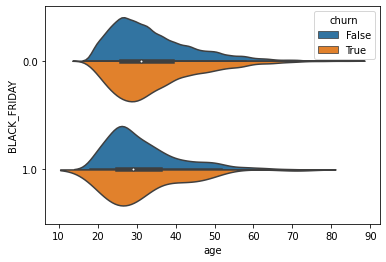

In [0]:
sns.violinplot(x=valid_cus['age'],
               y=valid_cus['BLACK_FRIDAY'].clip(upper=1),
               hue=valid_cus['churn'],
               split=True,
               orient='h')

# We can read the graph in two dimensions, 
# First, one can compare the orange regions of two rows.
# The slight difference in shape suggests that the 
# BLACK_FRIDAY notification can really affect the clients' intention
# to cease using our bank across different age groups.
# Secondly, at the bottom row, after the client receives at least 1 message about BLACK_FRIDAY,
# clients in 20 - 30 age group may decide to use keep using our bank in the future.
# This may suggest us to target younger users on black friday.

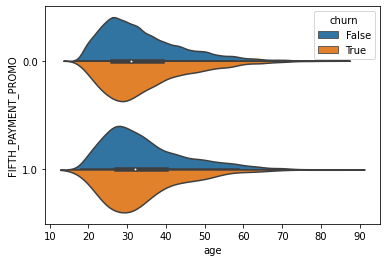

In [0]:
sns.violinplot(x=valid_cus['age'],
               y=valid_cus['FIFTH_PAYMENT_PROMO'].clip(upper=1),
               hue=valid_cus['churn'],
               split=True,
               orient='h')
# Unfortunately, the 4 halves of the graph look similar, this may suggest that
# FIFTH_PAYMENT_PROMO has the same effect across different age groups,
# but given that FIFTH_PAYMENT_PROMO statistically can reduce client churn rate.
# We keep blasting similar message in future campaigns.
# To better allocate resources, we should adopt the following
# framework in the future marketing campaign.

At last, to better allocate our future resources, <br>
I will suggest the following framework to the marketing team: <br>
Recall that our model separate clients into 5 groups (define it to be model groups), in each group, we may reserve a portion of clients (say 5%) that will not be targeted in the future marketing campaign (control group). <br>

In our next FIFTH_PAYMENT_PROMO campaign, apart from targeting the top 20% users, 
we should also target some users across different model groups. This will be very useful to track our campaign performance.<br>

Suppose after the campaign, the result is as follows:

In [0]:
eg = pd.DataFrame({'campaign_group_churn_rate':[0.11, 0.025, 0.02, 0.005, 0.01],
                    'control_group_churn_rate': [0.1, 0.05, 0.02, 0.01, 0.01]},
                      index=range(20, 101, 20))
display(eg)

,campaign_group_churn_rate,control_group_churn_rate
20,0.110,0.10
40,0.025,0.05
60,0.020,0.02
80,0.005,0.01
100,0.010,0.01


One can see that after the campaign, group 2 (20%-40%) and group 4 (60-80%)'s  <br>
churn rate was reduced, whereas the churn rate in group 1 (0%-20%) is similar to the control group, <br>
this suggests this campaign may not be attractive enough to retain them. <br>
After conducting t-test or other statistical tests, <br>
one may decide to allocate the same resources to group 2 and group 4 in the future.

### Main take way for the execution plan and metric:
1. target particular age group for Black friday message. <br>
2. Set up send out 'FIFTH_PAYMENT_PROMO' to all 5 model groups <br>
3. Gather the statistics of the campaign and set up, say t-test for the campaign evaluation.
4. Target the groups that have a significant decrease in churn rate if the same campaign is conducted in the future.


Thanks for joining this data science journey! I hope you enjoy this journey and I can proceed to the next stage!